In [1]:
import os
import shutil
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
!pip install nltk==3.7
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
pd.set_option("display.max_colwidth",None)
from google.cloud import storage
from pyspark.sql import Row

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
filtered=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sirivanth/new_filtered')

23/03/07 23:06:06 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
filtered.createOrReplaceTempView("filtered")

In [7]:
query = '''select tweet_text as text,
retweeted_status.id as r_status_id,
user.description as Description
from filtered'''
a = spark.sql(query)

In [8]:
#filtered.count()

In [9]:
a = a.sample(0.005)

In [10]:
a = a.withColumn("Organisation",when(col("Description").rlike('.*republic.*|.*congress.*|.*parliament.*|.*senat.*|.*president.*|.*democr.*|.*prime minister.*|.*Government.*|.*MLA.*|.*mla.*|.*gov.*|.*u.s..*|.*U.S..*|.*US.*|.*united states.*|.*government.*'),"Government")
                .when(col("Description").rlike('.*University.*|.*university.*|.*school.*|.*School.*|.*research.*|.*teaching.*|.*college.*|.*edu.*|.*graduate.*|.*undergraduate.*|.*bachelorsdegree.*|.*Bachelorsdegree.*|.*degree.*|.*Degree.*'),"Education")
                .when(col("Description").rlike('.*News.*|.*news.*|.*Media.*|.*media.*|.*journal.*|.*podcasts.*|.*podcast.*'),"News")
                .when(col("Description").rlike('.*nonprofit.*|.*Nonprofit.*|.*NGO.*|.*ngo.*|.*volunteers.*|.*Volunteers.*|.*Fundraising.*|.*fundraising.*|.*Charity.*|.*charity.*'),"NGO")
                .when(col("Description").rlike('.*influencer.*|.*Influencer.*|.*author.*|.*actress.*|.*musician.*|.*singer.*|.*crickter.*|.*Actor.*|.*actor.*|.*Actress.*|.*Cricter.*'),"Celebrity")
                .otherwise("Someone else"))                                                           

In [11]:
df = a.withColumn("tweet_type",when(col("r_status_id").isNull() != True,"retweet").otherwise("tweet"))

In [12]:
df.show()

+--------------------+-------------------+--------------------+------------+----------+
|                text|        r_status_id|         Description|Organisation|tweet_type|
+--------------------+-------------------+--------------------+------------+----------+
|ngl leaving colle...|1556729557029335040|Pansexual Soy Lat...|Someone else|   retweet|
|dr andrew’s offer...|1556393884577665026|Husband, father, ...|Someone else|   retweet|
|so school stuff, ...|1556510954870882306|Call me Motts
|Th...|Someone else|   retweet|
|not a single soul...|1604653808054935553|          she/her
💙|Someone else|   retweet|
|mitch mcconnell i...|1605198557098971136|Original intent o...|Someone else|   retweet|
|🚨 our online #pc...|1562441486746398721|Pennsylvania Coll...|  Government|   retweet|
|arizona state uni...|1620534812258996224|                null|Someone else|   retweet|
|dropped almost 2....|               null|If it makes you h...|Someone else|     tweet|
|senator shettima ...|161289443793

In [13]:
df = df.filter(col('tweet_type') == 'tweet')

In [14]:
df.show()

+--------------------+-----------+--------------------+------------+----------+
|                text|r_status_id|         Description|Organisation|tweet_type|
+--------------------+-----------+--------------------+------------+----------+
|dropped almost 2....|       null|If it makes you h...|Someone else|     tweet|
|@nickafterhack @l...|       null|All lives SHOULD ...|Someone else|     tweet|
|just posted a pho...|       null|Motivational #spe...|   Education|     tweet|
|@uimcclure univer...|       null|Our mission is to...|Someone else|     tweet|
|@hs_next_stop dor...|       null|CHS📚 class 23🎓 ...|Someone else|     tweet|
|u.s. supreme cour...|       null|My children & gra...|  Government|     tweet|
|@elisestefanik wo...|       null|Boston,Retired,#i...|Someone else|     tweet|
|the way my high s...|       null|Gwendolyn🥰TSU💙?...|Someone else|     tweet|
|i love college ht...|       null|     come back later|Someone else|     tweet|
|mamma mia &gt; hi...|       null|self-doubt

In [15]:
df1 = df.select('Organisation')

In [16]:
df1.show()

+------------+
|Organisation|
+------------+
|Someone else|
|Someone else|
|   Education|
|Someone else|
|Someone else|
|  Government|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
|  Government|
|Someone else|
|Someone else|
|Someone else|
|Someone else|
+------------+
only showing top 20 rows



In [17]:
df = df.select('text',substring('text',1,100)).withColumnRenamed("substring(text, 1, 100)","tweet_text")

In [18]:
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- tweet_text: string (nullable = true)



In [19]:
df.count()

20166

In [20]:
text_body = df.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

In [21]:
row = Row('text')
df_text = text_body.map(row).zipWithIndex().toDF(['tweet_text','id'])
df_text.limit(5)

tweet_text,id
{school teachers ...,168
{remember when yo...,169
{i have a “spend ...,170
{sculpture honour...,171
{@dahtribute @wes...,172


In [22]:
tokens = text_body\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [23]:
tokens_df = spark.createDataFrame(tokens, ["list_of_words",'id'])

In [24]:
tokens_df = tokens_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
df1 = df1.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

In [25]:
tokens_df = tokens_df.join(df1, on=["row_index"]).drop("row_index")
tokens_df = tokens_df.where(col('list_of_words').getItem(0).isNotNull())

In [26]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
vectorize_df = vectorize.fit(tokens_df).transform(tokens_df) 

23/03/07 23:11:05 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:11:05 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:12:30 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:12:30 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:12:30 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [27]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(vectorize_df)
hashed_df = mh.fit(vectorize_df).transform(vectorize_df)

In [28]:
hashed_text = df_text.join(hashed_df, "id", how = 'left')

# 0.5

In [29]:
jaccard_distance = 0.6
df_dups_text_30 = model.approxSimilarityJoin(hashed_text, hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),col("datasetA.Organisation").alias('Organisation'),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

In [30]:
df_dups_txt_30 = df_dups_text_30
df_dups_text_30.limit(20).toPandas().sort_values('distCol',ascending=False)

23/03/07 23:12:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:12:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:12:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:12:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:15:23 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,distCol,Organisation,id_A,id_B,text_A,text_B
14,0.590909,Someone else,468,9151,"(seton lasalle vs fort cherry | pennsylvania high school baseball 2022 live stream | click here watch,)","(mynderse academy vs gananda central | new york high school baseball 2022 live stream | click here wa,)"
0,0.571429,Someone else,1326,1486,"(the nicest american school teacher,)","(the fun high school teacher,)"
17,0.571429,Someone else,3858,17996,"(me in high school,)","(he was a safety in high school,)"
15,0.571429,Someone else,11255,11342,"(i believe in high school musical 2 supremacy,)","(me in high school,)"
5,0.571429,Someone else,3779,12518,"(me in high school,)","(yea he wrestled in high school,)"
8,0.550000,Someone else,4320,5862,"(beverly vs central catholic | ma high school baseball 2022 live stream | click here watch live hd: h,)","(ayersville vs bluffton | high school football 2022 live streaming | click here watch live hd: https:,)"
13,0.550000,Someone else,1767,11383,"(connellsville vs bethel park | pa high school baseball 2022 live stream | click here watch live hd =,)","(centerville vs miamisburg | high school football 2022 live stream | click here watch live hd: https:,)"
19,0.550000,Someone else,7314,10957,"(bertie vs perquimans | north carolina high school baseball 2022 live stream | click here watch live ,)","(lakota east vs sycamore | high school football 2022 live stream | click here watch live hd: https://,)"
7,0.550000,Someone else,4320,10142,"(beverly vs central catholic | ma high school baseball 2022 live stream | click here watch live hd: h,)","(riceville vs turkey valley | high school football live stream | click here watch live hd: https://t.,)"
1,0.500000,Someone else,2243,13403,"(@sainttxo me in high school,)","(she's in high school,)"


In [31]:
records = hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30

print ('Total records: ', records)
print ('Duplicate Tweets based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique Tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/07 23:16:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:16:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:19:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:19:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:19:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Total records:  20166
Duplicate Tweets based on { 0.6 } jaccard distance:  1005
Unique Tweets based on { 0.6 } jaccard distance:  0.6 :  19161


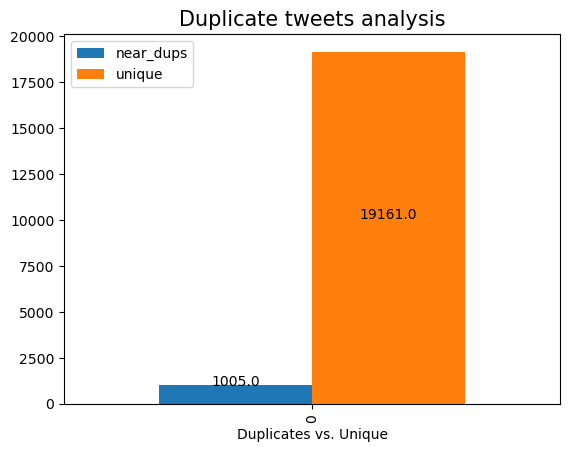

In [32]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicate tweets analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [33]:
df_dups_text_30.createOrReplaceTempView("filtered")

In [34]:
dup_df = spark.sql('select Organisation,count(*) from filtered group by Organisation').toPandas()

23/03/07 23:24:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:24:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:24:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:24:00 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:26:18 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [35]:
dup_df

,Organisation,count(1)
0,News,172
1,Education,406
2,Someone else,3064
3,Government,320
4,NGO,10
5,Celebrity,12


In [36]:
hashed_text.createOrReplaceTempView("filtered")

In [37]:
all_df = spark.sql('select Organisation,count(*) from filtered group by Organisation').toPandas()

23/03/07 23:28:56 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:28:56 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:31:27 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:31:27 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/07 23:31:28 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [38]:
all_df

,Organisation,count(1)
0,Education,1323
1,Government,1923
2,NGO,53
3,Someone else,15495
4,Celebrity,185
5,News,1187


In [47]:
dup_df.sort_values(by='Organisation',inplace=True)

In [48]:
dup_df

,Organisation,count(1)
5,Celebrity,12
1,Education,406
3,Government,320
4,NGO,10
0,News,172
2,Someone else,3064


In [50]:
all_df.sort_values(by='Organisation',inplace=True)

In [51]:
all_df

,Organisation,count(1)
4,Celebrity,185
0,Education,1323
1,Government,1923
2,NGO,53
5,News,1187
3,Someone else,15495


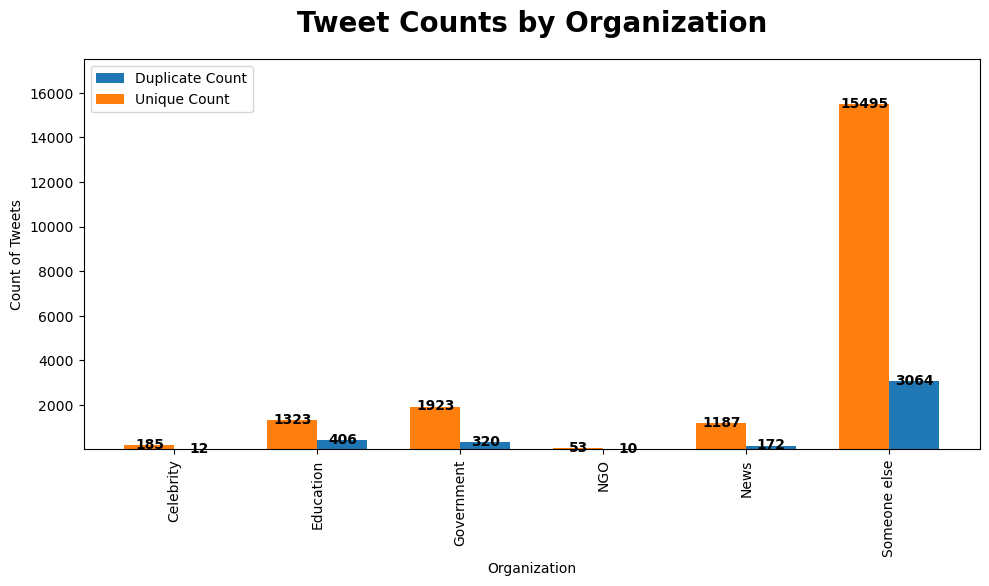

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define the figure size and colors for bars
fig, ax = plt.subplots(figsize=(10, 6))
colors = list(mcolors.TABLEAU_COLORS.values())

# Define the bar properties
bar_width = 0.35
opacity = 0.8

# Plot the bars for duplicate and unique tweet counts
index = np.arange(len(dup_df['Organisation']))
index2 = np.arange(len(all_df['Organisation']))
ax.bar(index, dup_df['count(1)'], color=colors[0], align='edge', width=bar_width, label='Duplicate Count')
ax.bar(index2, all_df['count(1)'], color=colors[1], align='edge', width=-bar_width, label='Unique Count')

# Customize the X-axis tick labels and rotation
ax.set_xticks(index)
ax.set_xticklabels(dup_df['Organisation'], rotation=90)

# Add axis labels and legend
ax.set_xlabel('Organization')
ax.set_ylabel('Count of Tweets')
ax.legend()

# Customize the Y-axis limits and tick marks
ax.set_ylim([1, 17500])

# Customize the plot title and subtitle
ax.set_title('Tweet Counts by Organization', fontsize=20, fontweight='bold', y=1.05)

# Add the count above each bar
for i, v in enumerate(dup_df['count(1)']):
    ax.text(i + bar_width/2, v + 30, str(v), ha='center', va='center', fontweight='bold', color='black')
for i, v in enumerate(all_df['count(1)']):
    ax.text(i - bar_width/2, v + 30, str(v), ha='center', va='center', fontweight='bold', color='black')

# Show the plot
plt.tight_layout()
plt.show()
